# Projeto 10 

### Descrição do Projeto

Contexto:
Você decidiu abrir uma pequena cafeteria com garçons robôs em Los Angeles. É um
projeto bem promissor, mas caro, então você e seus parceiros decidem tentar atrair
investidores. Eles estão interessados nas condições atuais do mercado e querem saber
se você conseguirá manter seu sucesso quando a novidade de garçons robôs
esmorecer.
Você é um guru de análise, então seus parceiros te pediram para preparar uma
pesquisa do mercado. Você tem dados de código aberto sobre restaurantes em LA.

### Índice

1. [Carregamento dos dados e preparo para análise](#1)
2. [Análise de dados](#2)
    * [Proporções de vários tipos de estabelecimentos](#21)
    * [Proporções de estabelecimentos de rede e não rede](#22)
    * [Tipos de estabelecimento típico para redes](#23)
    * [O que caracteriza redes: muitos estabelecimentos com um pequeno número de assentos ou poucos estabelecimentos com muitos assentos?](#24)
    * [Número médio de assentos para cada tipo de estabelecimento](#25)
    * [Investigando locais mais concorridos](#26)
    * [Top 10 ruas com o maior número de restaurantes](#27)
    * [Número de ruas que têm apenas um restaurante](#28)
    * [Distribuição de número de assentos para as ruas com muitos restaurantes](#29)
    * [Proporção tipo de estabelecimentos nas ruas mais famosas](#210)
3. [Conclusão](#3)

#### <a id="1">Passo 1. Carregamento dos dados e preparo para a análise</a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 2.5})

In [2]:
df = pd.read_csv('rest_data_us.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9651 non-null   int64 
 1   object_name  9651 non-null   object
 2   address      9651 non-null   object
 3   chain        9648 non-null   object
 4   object_type  9651 non-null   object
 5   number       9651 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 452.5+ KB


* Colunas com formato de dados correto 
* Colunas no formato snake case 
* 3 dados ausentes na coluna chain 

In [4]:
df.head()

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


In [5]:
# checking duplicates

print(df.duplicated().sum())
print(df.duplicated(subset=['id']).sum())
print(df.duplicated(subset=['object_name', 'address']).sum())

0
0
0


In [6]:
# checking null values
df[df['chain'].isna()]

,id,object_name,address,chain,object_type,number
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,NaN,Restaurant,14
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,NaN,Restaurant,35


In [7]:
chain_nan = ["TAQUERIA LOS 3 CARNALES",
             "JAMMIN JIMMY'S PIZZA", "THE LEXINGTON THEATER"]
df[df['object_name'].isin(chain_nan)]

,id,object_name,address,chain,object_type,number
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,NaN,Restaurant,14
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,NaN,Restaurant,35


Para ser considerado uma rede um restaurante deve possuir 2 estabelecimentos ou mais, nesse caso vimos que os restaurantes com valor ausente na coluna chain só possui um restaurante, portanto o valor ausente vai ser substituido por False.

In [8]:
df['chain'].fillna(False, inplace=True)
df[df['chain'].isna()]

,id,object_name,address,chain,object_type,number


In [9]:
df.describe(include='object')

,object_name,address,object_type
count,9651,9651,9651
unique,8672,8517,6
top,THE COFFEE BEAN & TEA LEAF,3607 TROUSDALE PKWY,Restaurant
freq,47,11,7255


#### <a id="2">Passo 2. Análise de dados</a>

##### <a id="21">Proporções de vários tipos de estabelecimentos</a>

In [10]:
# count object_type
type_count = df['object_type'].value_counts()

# plot
fig = go.Figure(
    data=[go.Pie(labels=type_count.index, values=type_count.values)])
fig.update_layout(title_text='Proporção dos Tipos de Estabelecimentos',
                  title_x=0.5)
fig.show()

Maioria esmagadora de restaurantes 

##### <a id="22">Proporções de estabelecimentos de rede e não rede</a>

In [11]:
# chain counts
chain_counts = df['chain'].value_counts()

# plot
fig = go.Figure(
    data=[go.Pie(labels=chain_counts.index, values=chain_counts.values)])
fig.update_layout(
    title_text='Proporção de Estabelecimentos que são de Rede (Chain)',
    title_x=0.5)
fig.show()

Maioria não é rede, 61.9%

##### <a id="23">Tipos de estabelecimento típico para redes</a>

In [12]:
# filter
df_chain_true = df[df['chain'] == True]

# group by type
df_group_chain_obtype = df_chain_true.groupby(
    'object_type')['object_type'].count().sort_values(ascending=False)

# plot
fig = px.bar(df_group_chain_obtype, x=df_group_chain_obtype.index,
             y=df_group_chain_obtype.values, color=df_group_chain_obtype.index)
fig.update_layout(
    title="Tipos de estabelecimento típico para redes (Chain)",
    xaxis_title="Tipo de estabelecimento",
    yaxis_title="Número de estabelecimentos",
    title_x=0.5,  # Centraliza o título
    legend_title="Estabelecimento"
)

fig.show()

Maioria esmagadora de restaurante como estabelecimento típicos de redes, mas também temos o fast food com bons números

##### <a id="24">O que caracteriza redes: muitos estabelecimentos com um pequeno número de assentos ou poucos estabelecimentos com muitos assentos?</a>

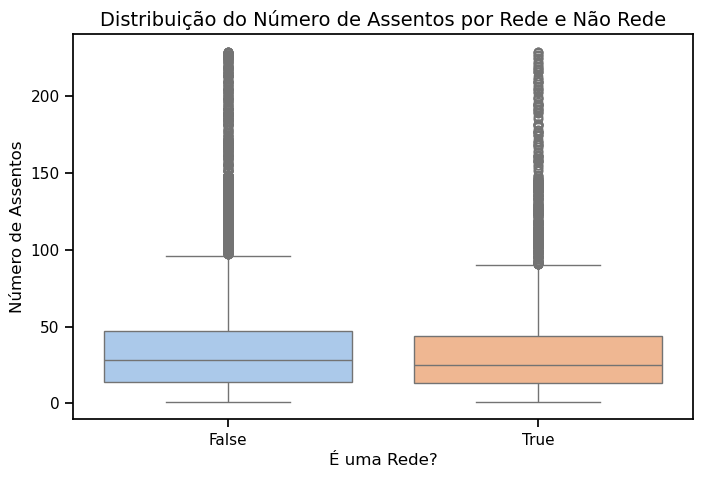

In [25]:
# Boxplot number of seats, chain and no chain

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="chain", y="number", palette='pastel')

plt.title("Distribuição do Número de Assentos por Rede e Não Rede", fontsize=14)
plt.xlabel("É uma Rede?", fontsize=12)
plt.ylabel("Número de Assentos", fontsize=12)

plt.show()

Somente por número de assentos não se caracteriza como rede ou não, boxplot tem números parecidos

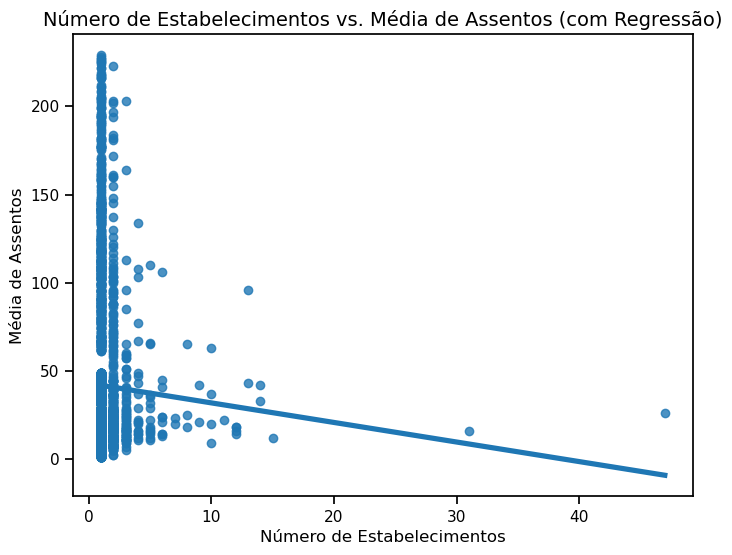

In [14]:
# count number of seats per chain
df_chain_seats = df_chain_true.groupby('object_name').agg(total_estabelecimentos=(
    "id", "count"), media_assentos=("number", "mean")).reset_index()
df_chain_seats['media_assentos'] = df_chain_seats['media_assentos'].astype(int)

# scatter plot
plt.figure(figsize=(8, 6))
sns.regplot(data=df_chain_seats, x="total_estabelecimentos",
            y="media_assentos", scatter=True, ci=None)

plt.title(
    "Número de Estabelecimentos vs. Média de Assentos (com Regressão)", fontsize=14)
plt.xlabel("Número de Estabelecimentos", fontsize=12)
plt.ylabel("Média de Assentos", fontsize=12)

plt.show()

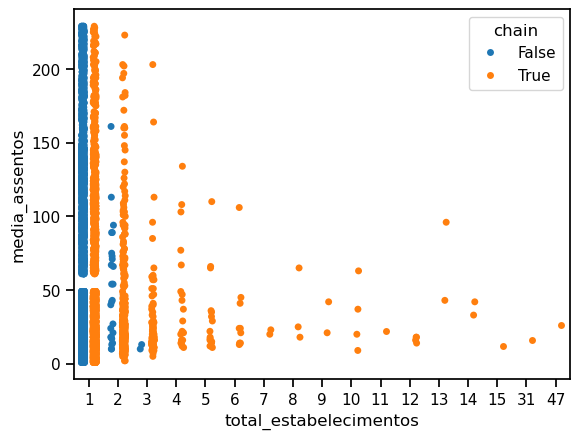

In [15]:
# stripplot
df_groupped = df.groupby(['chain', 'object_name']).agg(total_estabelecimentos=(
    "id", "count"), media_assentos=("number", "mean")).reset_index()
df_groupped['media_assentos'] = df_groupped['media_assentos'].astype(int)

sns.stripplot(x="total_estabelecimentos", y="media_assentos",
              data=df_groupped, hue='chain', dodge=True, jitter=True)
plt.show()

Segundo os gráficos de dispersão as redes se caracterizam por poucos estabelecimentos com média de muitos assentos 

##### <a id="25">Número médio de assentos para cada tipo de estabelecimento</a>

In [16]:
# group by
df_seats_per_obtype = df.groupby('object_type')['number'].mean().reset_index()
df_seats_per_obtype.sort_values(by='number', ascending=False, inplace=True)

# plot
fig = px.bar(df_seats_per_obtype, x='object_type',
             y='number', color='object_type')
fig.update_layout(
    title="Número de assentos por tipo de estabelecimento",
    xaxis_title="Tipo de estabelecimento",
    yaxis_title="Média número de assenntos",
    title_x=0.5,
    legend_title="Estabelecimento"
)

fig.show()

Restaurante e bar são os estabelecimentos com maiores média de número de assentos

##### <a id="26">Investigando locais mais concorridos</a>

In [17]:
# saving just street name
df['street_name'] = df['address'].str.replace(
    r'[^a-zA-ZÀ-ÿ\s]', '', regex=True)

# regex=True: regular expression
# r'[^a-zA-ZÀ-ÿ\s]': Removes everything other than:
# Uppercase letters (A-Z)
# Lowercase letters (a-z)
# Accented letters (À-ÿ)
# Spaces (\s)

df.head()

,id,object_name,address,chain,object_type,number,street_name
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26,N EAGLE ROCK BLVD
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9,WORLD WAY
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20,HOLLYWOOD BLVD
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22,W SUNSET BLVD
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20,ECHO PARK AVE


##### <a id="27">Top 10 ruas com o maior número de restaurantes</a>

In [18]:
restaurants_by_streets = df.groupby('street_name')['id'].count().reset_index()

# top10
top10_streets = restaurants_by_streets.sort_values(
    by='id', ascending=False).head(10)

# plt
fig = px.bar(top10_streets, x='street_name',
             y='id', color='street_name')
fig.update_layout(
    title="Top 10 Ruas por número de estabelecimentos",
    xaxis_title="Ruas",
    yaxis_title="Número de restaurantes",
    title_x=0.5,
    showlegend=False
)

fig.show()

W TH ST, W SUNSET BLVD, W PICO BLVD são as três ruas com maior número de estabelecimentos 

##### <a id="28">Número de ruas que têm apenas um restaurante.</a>

In [19]:
len(restaurants_by_streets[restaurants_by_streets['id'] == 1])

1096

1096 ruas com apenas um restaurante 

##### <a id="29">Distribuição de número de assentos para as ruas com muitos restaurantes.</a>

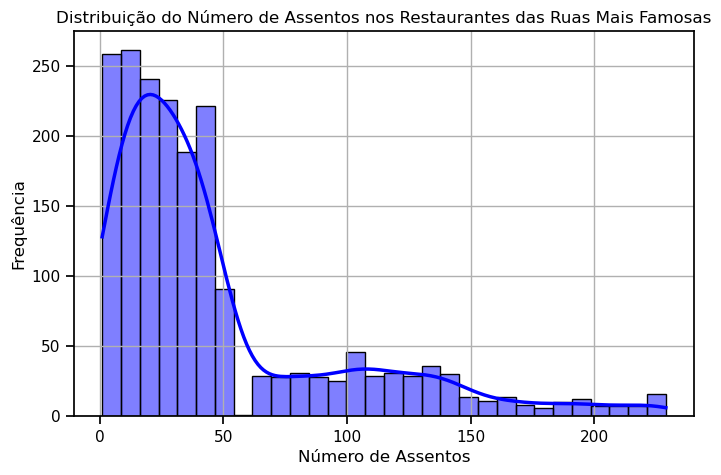

In [24]:
list_top_streets = top10_streets['street_name']

df_filtered_top_streets = df[df['street_name'].isin(list_top_streets)]

# plot
plt.figure(figsize=(8, 5))
sns.histplot(df_filtered_top_streets["number"],
             kde=True, bins=30, color='blue')

# Personalizar
plt.title("Distribuição do Número de Assentos nos Restaurantes das Ruas Mais Famosas", fontsize=12)
plt.xlabel("Número de Assentos", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.grid(True)

# Exibir gráfico
plt.show()

Nas ruas mais requisitadas para esse tipo de serviço, a uma têndencia dos restaurantes em ter menos 50 assentos

##### <a id="210">Proporção tipo de estabelecimentos nas ruas mais famosas</a>

In [21]:
type_count = df_filtered_top_streets['object_type'].value_counts()

# plot
fig = go.Figure(
    data=[go.Pie(labels=type_count.index, values=type_count.values)])
fig.update_layout(title_text='Proporção dos Tipos de Estabelecimentos nas Ruas mais Famosas',
                  title_x=0.5)
fig.show()

### <a id="3">Conclusão: Conclusão geral e recomendações</a>

Análisando os gráficos nota-se que há certas têndencias como:
* Maioria esmagadora dos estabelecimentos são restaurantes tanto nas ruas mais famosas como no geral
* Há mais restaurantes de redes (60% contra 40%)
* Segundo os gráficos de dispersão as redes se caracterizam por poucos estabelecimentos com média de muitos assentos 
* Restaurante e bar são os estabelecimentos com maior média de número de assentos (50)
* Nas ruas mais requisitadas para esse tipo de serviço, a uma têndencia dos restaurantes em ter menos de 50 assentos

Como há uma concorrência muito forte para o tipo de estabelecimento restaurante, é super recomendável abrir um outro tipo de estabelecimento, como um bar ou café, sobre o número de assentos dependeria do local de abertura, se fosse o caso de abrir em um local famoso onde já existe bastante estabelecimentos, recomendaria um lugar com poucos assentos por conta do preço do aluguel que provavelmente deve ser mais caro e também poderia dar um ar de 'exclusividade' não só pelo o número limitado de assentos mais por conta da novidade de garçons rôbos. Já se abertura do estabelecimento não fosse em um lugar tão requisitados, recomendaria um número alto de assentos para um retorno do investimento mais rápido. Dependendo do sucesso do novo negócio, recomendaria investir em uma rede mas seguindo a mesma mentalidade inicial de (lugares famosos, assentos exclusivos / lugares comuns, muitos assentos)

Report em pdf e apresentação html desse projeto: <[Github](https://github.com/aguilhermerg/tripleten_projects)> 

relatório em PDF:
jupyter nbconvert --to pdf project_10_teste_presentation.ipynb

Exporte para slides em HTML com código:
jupyter nbconvert --to slides project_10_teste_presentation.ipynb --post serve

Sem código only output: 
jupyter nbconvert project_10_teste_presentation.ipynb --to slides --no-input --execute   (plotly funciona)

Salvar como PDF:
No navegador, pressione Ctrl + P (ou "Imprimir").
Escolha Salvar como PDF.

Tipo de Cada Célula
Agora, para cada célula do notebook, defina uma das seguintes opções no menu de :

Tipo de slide que deseja aplicar às células selecionadas:

Slide: A célula será um slide principal.

Sub-slide: A célula será um sub-slide (transição vertical).

Fragment: A célula será exibida como um fragmento (aparece gradualmente no mesmo slide).

Skip: A célula não será exibida na apresentação.

Notes: A célula será usada como notas (não aparece na apresentação).

resetar metadados:
jupyter nbconvert seu_notebook.ipynb --clear-metadata --inplace